## ETH Model deployment

This notebook will import new data to feed into the trained LSTM model and produce csvs of close price and predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime as dt
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from keras.models import load_model

from api_keys import coinapi_key

In [2]:
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&&time_start=2023-01-02T00:00:00&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-01-02T00:00:00.0000000Z', 'time_period_end': '2023-01-03T00:00:00.0000000Z', 'time_open': '2023-01-02T00:00:30.8560000Z', 'time_close': '2023-01-02T23:59:58.0220000Z', 'price_open': 1200.2, 'price_high': 1222.9, 'price_low': 1193, 'price_close': 1214.5, 'volume_traded': 8513.89427594, 'trades_count': 5484}, {'time_period_start': '2023-01-03T00:00:00.0000000Z', 'time_period_end': '2023-01-04T00:00:00.0000000Z', 'time_open': '2023-01-03T00:00:06.0750000Z', 'time_close': '2023-01-03T23:59:54.5080000Z', 'price_open': 1214.5, 'price_high': 1219.5, 'price_low': 1204.9, 'price_close': 1214.5, 'volume_traded': 5296.58034653, 'trades_count': 5857}, {'time_period_start': '2023-01-04T00:00:00.0000000Z', 'time_period_end': '2023-01-05T00:00:00.0000000Z', 'time_open': '2023-01-04T00:01:16.7410000Z', 'time_close': '2023-01-04T23:59:20.8760000Z', 'price_open': 1214.3, 'price_high': 1270.2, 'price_low': 1212.6, 'price_close': 1256.5, 'volume_traded': 15768.16265551, 'trade

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:30.8560000Z,2023-01-02T23:59:58.0220000Z,1200.2,1222.9,1193.0,1214.5,8513.894276,5484
1,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:06.0750000Z,2023-01-03T23:59:54.5080000Z,1214.5,1219.5,1204.9,1214.5,5296.580347,5857
2,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:01:16.7410000Z,2023-01-04T23:59:20.8760000Z,1214.3,1270.2,1212.6,1256.5,15768.162656,7823
3,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:01:08.8800000Z,2023-01-05T23:59:39.8980000Z,1256.5,1259.5,1242.2,1250.6,7160.411004,6075
4,2023-01-06T00:00:00.0000000Z,2023-01-07T00:00:00.0000000Z,2023-01-06T00:00:04.9020000Z,2023-01-06T23:59:06.5040000Z,1250.9,1276.0,1235.6,1269.2,9404.155065,7289


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2023-01-02,1214.5
2023-01-03,1214.5
2023-01-04,1256.5
2023-01-05,1250.6
2023-01-06,1269.2
...,...
2023-12-05,2293.9
2023-12-06,2233.4
2023-12-07,2358.3


In [5]:
close = data['Close']

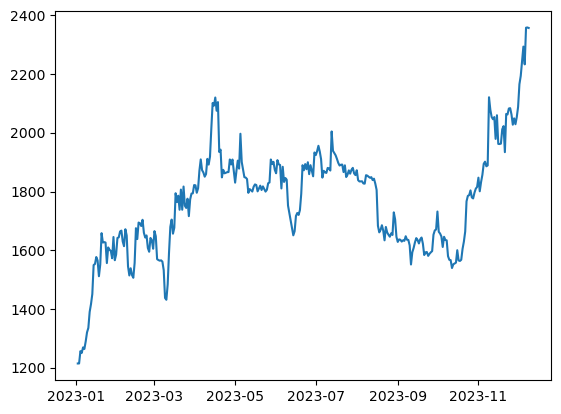

In [6]:
#plot historical eth price
plt.plot(close)

In [7]:
# build 6 day lookback windows for lstm prediction
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 6
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6)
Date,,,,,,,
2023-01-08,1289.6,1263.9,1269.2,1250.6,1256.5,1214.5,1214.5
2023-01-09,1320.5,1289.6,1263.9,1269.2,1250.6,1256.5,1214.5
2023-01-10,1335.5,1320.5,1289.6,1263.9,1269.2,1250.6,1256.5
2023-01-11,1390.2,1335.5,1320.5,1289.6,1263.9,1269.2,1250.6
2023-01-12,1416.6,1390.2,1335.5,1320.5,1289.6,1263.9,1269.2
...,...,...,...,...,...,...,...
2023-12-05,2293.9,2243.8,2194.1,2165.8,2088.6,2053.8,2029.4
2023-12-06,2233.4,2293.9,2243.8,2194.1,2165.8,2088.6,2053.8
2023-12-07,2358.3,2233.4,2293.9,2243.8,2194.1,2165.8,2088.6


In [8]:
#create array of dates for plotting from new index (needs to account for dropped dates that
# are abosrbed into the first lookback window. 

dates = shifted_df.index
dates.shape

(325,)

In [9]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

#Log transform df to scale data for prediction
shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np_int)

log_transformed_data.shape

(325, 7)

In [10]:
#Flip lookback axis so that most recent day is last -7, -6, -5, -4, -3, -2, -1, predict next
X = dc(np.flip(log_transformed_data, axis=1))

In [11]:
#Load trained model
model = load_model("H5_Files/eth_7_day_1.h5")

In [12]:
#build predictions for first model
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))


# Use last (most recent) window to predict next day
current_batch = X[-1]
current_reshape = current_batch.reshape((1, 7))
initial_date = dates[-1]


for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, 7))

#Add future dates for predictions   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 9ms/step


2023-12-09 18:17:06.486999: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 7ms/step
[7.713573, 7.706062, 7.70679, 7.708234, 7.7087326, 7.7086926, 7.7085977]
2023-12-10
2023-12-11
2023-12-12
2023-12-13
2023-12-14
2023-12-15
2023-12-16


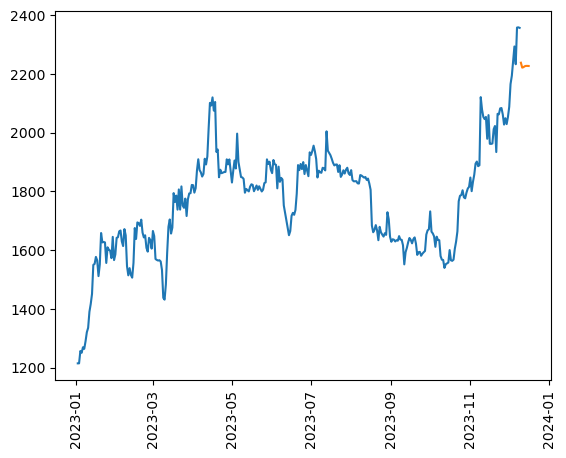

In [13]:
plt.plot(close)
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)

plt.show()

In [14]:
#load trained model 2
model2 = load_model("H5_Files/eth_7_day_2.h5")
#load trained model 3
model3 = load_model("H5_Files/eth_7_day_3.h5")

In [15]:
#build predictions for second 2 models


# Initialize an array to store predictions
predictions2 = []
prediction_range2 = 7

current_batch = X[-1]
current_reshape = current_batch.reshape((1, 7))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model2.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions2.append(current_pred)
        
    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, 7))

    #build predictions for first model


    # Initialize an array to store predictions
predictions3 = []
prediction_range3 = 7

current_batch = X[-1]
current_reshape = current_batch.reshape((1, 7))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions3.append(current_pred)
        
    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, 7))

print(predictions2)
print(predictions3)


1/1 [==============================] - 0s 8ms/step
[7.7475967, 7.7500305, 7.750889, 7.750716, 7.7474084, 7.746481, 7.7462845]
[7.8166323, 7.8234344, 7.822686, 7.821761, 7.8215113, 7.821571, 7.8214755]


In [16]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates, "observed":close[lookback:]})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions),\
                    "future_prediction2": np.exp(predictions2), "future_prediction3": np.exp(predictions3)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,future_prediction,future_prediction2,future_prediction3
Date,,,,
2023-01-08,1289.6,NaN,NaN,NaN
2023-01-09,1320.5,NaN,NaN,NaN
2023-01-10,1335.5,NaN,NaN,NaN
2023-01-11,1390.2,NaN,NaN,NaN
2023-01-12,1416.6,NaN,NaN,NaN


In [17]:
past_future_df.tail()

,observed,future_prediction,future_prediction2,future_prediction3
Date,,,,
2023-12-12,NaN,2223.393555,2323.636719,2496.602783
2023-12-13,NaN,2226.606201,2323.235840,2494.294434
2023-12-14,NaN,2227.717041,2315.563477,2493.671143
2023-12-15,NaN,2227.627930,2313.416992,2493.819824
2023-12-16,NaN,2227.416504,2312.962646,2493.582031


In [18]:
pred_columns = past_future_df[['future_prediction','future_prediction2','future_prediction3' ]]

pred_means = pred_columns.mean(axis=1)

past_future_df['mean'] = pred_means

past_future_df

,observed,future_prediction,future_prediction2,future_prediction3,mean
Date,,,,,
2023-01-08,1289.6,NaN,NaN,NaN,NaN
2023-01-09,1320.5,NaN,NaN,NaN,NaN
2023-01-10,1335.5,NaN,NaN,NaN,NaN
2023-01-11,1390.2,NaN,NaN,NaN,NaN
2023-01-12,1416.6,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-12-12,NaN,2223.393555,2323.636719,2496.602783,2347.877686
2023-12-13,NaN,2226.606201,2323.235840,2494.294434,2348.045410
2023-12-14,NaN,2227.717041,2315.563477,2493.671143,2345.650391


In [19]:
past_future_df.to_csv('output/eth_model.csv') 